<center>
    <h1>Target Trial Emulation</h1>
    By Christian Abay-abay & Thristan Jay Nakila
</center>

## **Instructions**

1. Extract the dummy data from [RPubs - TTE](https://rpubs.com/alanyang0924/TTE) and save it as `data_censored.csv`.
2. Convert the R code to Python in a Jupyter Notebook, ensuring the results match the original.
3. Create a second version (`TTE-v2.ipynb`) with additional analysis.
4. Integrate clustering in `TTE-v2`, determine where it fits, and generate insights.
5. Work in pairs, preferably with your thesis partner.
6. Push your Jupyter Notebooks (`TTE.ipynb` and `TTE-v2.ipynb`) to GitHub.
7. 📅 **Deadline:** February 28, 2025, at **11:59 PM**.


***
<center>
    <h2>R Code converted to Python</h2>
    R Code from [RPubs - TTE](https://rpubs.com/alanyang0924/TTE) converted to Python code for this notebook.
</center>

In [20]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
import matplotlib.pyplot as plt

In [21]:

class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.data = None
        self.censor_weights = None
        self.switch_weights = None if estimand != "Per-Protocol" else {}
        self.expanded_data = None
        self.outcome_model = None
        self.outcome_data = None
        self.save_dir = None

    def set_data(self, data, id="id", period="period", treatment="treatment", outcome="outcome", eligible="eligible", censor_event="censored"):
        data = data.rename(columns={id: "id", period: "period", treatment: "treatment", outcome: "outcome", eligible: "eligible", censor_event: "censored"})
        data = data.sort_values(by=["id", "period"])
        data["treatment_lag"] = data.groupby("id")["treatment"].shift(1).fillna(0)
        if self.estimand == "Per-Protocol":
            data["switch"] = (data["treatment"] != data["treatment_lag"]) & (~data["treatment_lag"].isna())
        self.data = data
        return self

    def set_censor_weight_model(self, censor_event, numerator, denominator, pool_models, model_fitter, save_path=None):
        self.censor_weights = {
            "censor_event": censor_event,
            "numerator": numerator,
            "denominator": denominator,
            "pool_models": pool_models,
            "model_fitter": model_fitter,
            "save_path": save_path,
            "fitted_models": {}
        }
        return self

    def set_switch_weight_model(self, numerator, denominator, model_fitter, save_path=None):
        if self.estimand != "Per-Protocol":
            raise ValueError("Switch weights are only applicable for Per-Protocol estimand.")
        self.switch_weights = {
            "numerator": numerator,
            "denominator": denominator,
            "model_fitter": model_fitter,
            "save_path": save_path,
            "fitted_models": {}
        }
        return self

    def print_model_summary(self, model, title):
        print(f"{title}:")
        print("term        estimate   std.error statistic p.value")
        for param in model.params.index:
            term = "(Intercept)" if param == "Intercept" else param
            estimate = model.params[param]
            std_error = model.bse[param]
            statistic = model.tvalues[param]
            p_value = model.pvalues[param]
            print(f"{term:<12}{estimate:>10.6f}{std_error:>12.6f}{statistic:>10.4f}{p_value:>12.4e}")
        null_deviance = -2 * model.llnull
        deviance = -2 * model.llf
        df_null = int(model.nobs - 1)
        print("\nnull.deviance df.null logLik    AIC      BIC      deviance df.residual nobs")
        print(f"{null_deviance:>13.4f}{df_null:>8d}{model.llf:>10.4f}{model.aic:>10.4f}{model.bic:>10.4f}{deviance:>10.4f}{int(model.df_resid):>12d}{int(model.nobs):>5d}")
        print()

    def calculate_weights(self):
        if self.censor_weights is None:
            raise ValueError("Censor weight model not specified.")
        
        data = self.data.copy()
        censor_event = self.censor_weights["censor_event"]
        data["not_censored"] = 1 - data[censor_event]
        
        print(f"Step 4: Weight Models for Informative Censoring ({self.estimand})")
        print("---------------------------------------")
        
        # Censor weights
        if self.censor_weights["pool_models"] == "numerator":
            # Pooled numerator
            num_formula = f"not_censored ~ {self.censor_weights['numerator']}"
            model_n = smf.logit(num_formula, data=data).fit(disp=0)
            self.censor_weights["fitted_models"]["n"] = model_n
            
            den_formula = f"not_censored ~ {self.censor_weights['denominator']}"
            model_d0 = smf.logit(den_formula, data=data[data["treatment_lag"] == 0]).fit(disp=0)
            model_d1 = smf.logit(den_formula, data=data[data["treatment_lag"] == 1]).fit(disp=0)
            self.censor_weights["fitted_models"]["d0"] = model_d0
            self.censor_weights["fitted_models"]["d1"] = model_d1
            
            data["censor_prob_num"] = model_n.predict(data)
            data["censor_prob_den"] = np.where(
                data["treatment_lag"] == 0,
                model_d0.predict(data),
                model_d1.predict(data)
            )
            self.print_model_summary(model_n, "Numerator Model (Pooled)")
            self.print_model_summary(model_d0, "Denominator Model (Treatment Lag = 0)")
            self.print_model_summary(model_d1, "Denominator Model (Treatment Lag = 1)")
        else:  # "none" pooling (PP default)
            num_formula = f"not_censored ~ {self.censor_weights['numerator']}"
            model_n0 = smf.logit(num_formula, data=data[data["treatment_lag"] == 0]).fit(disp=0)
            model_n1 = smf.logit(num_formula, data=data[data["treatment_lag"] == 1]).fit(disp=0)
            den_formula = f"not_censored ~ {self.censor_weights['denominator']}"
            model_d0 = smf.logit(den_formula, data=data[data["treatment_lag"] == 0]).fit(disp=0)
            model_d1 = smf.logit(den_formula, data=data[data["treatment_lag"] == 1]).fit(disp=0)
            self.censor_weights["fitted_models"]["n0"] = model_n0
            self.censor_weights["fitted_models"]["n1"] = model_n1
            self.censor_weights["fitted_models"]["d0"] = model_d0
            self.censor_weights["fitted_models"]["d1"] = model_d1
            
            data["censor_prob_num"] = np.where(
                data["treatment_lag"] == 0,
                model_n0.predict(data),
                model_n1.predict(data)
            )
            data["censor_prob_den"] = np.where(
                data["treatment_lag"] == 0,
                model_d0.predict(data),
                model_d1.predict(data)
            )
            self.print_model_summary(model_n0, "Numerator Model (Treatment Lag = 0)")
            self.print_model_summary(model_n1, "Numerator Model (Treatment Lag = 1)")
            self.print_model_summary(model_d0, "Denominator Model (Treatment Lag = 0)")
            self.print_model_summary(model_d1, "Denominator Model (Treatment Lag = 1)")
        
        data["wtC"] = data["censor_prob_num"] / data["censor_prob_den"]
        data["wtC"] = data.groupby("id")["wtC"].cumprod()
        
        # Switch weights (PP only)
        if self.estimand == "Per-Protocol" and self.switch_weights:
            data["stayed_on_treatment"] = (~data["switch"]).astype(int)
            num_formula = f"stayed_on_treatment ~ {self.switch_weights['numerator']}"
            den_formula = f"stayed_on_treatment ~ {self.switch_weights['denominator']}"
            
            model_n0 = smf.logit(num_formula, data=data[data["treatment_lag"] == 0]).fit(disp=0)
            model_n1 = smf.logit(num_formula, data=data[data["treatment_lag"] == 1]).fit(disp=0)
            model_d0 = smf.logit(den_formula, data=data[data["treatment_lag"] == 0]).fit(disp=0)
            model_d1 = smf.logit(den_formula, data=data[data["treatment_lag"] == 1]).fit(disp=0)
            self.switch_weights["fitted_models"]["n0"] = model_n0
            self.switch_weights["fitted_models"]["n1"] = model_n1
            self.switch_weights["fitted_models"]["d0"] = model_d0
            self.switch_weights["fitted_models"]["d1"] = model_d1
            
            data["switch_prob_num"] = np.where(
                data["treatment_lag"] == 0,
                model_n0.predict(data),
                model_n1.predict(data)
            )
            data["switch_prob_den"] = np.where(
                data["treatment_lag"] == 0,
                model_d0.predict(data),
                model_d1.predict(data)
            )
            data["wtS"] = data["switch_prob_num"] / data["switch_prob_den"]
            data["wtS"] = data.groupby("id")["wtS"].cumprod()
            data["weight"] = data["wtC"] * data["wtS"]
            
            print("Switch Weight Models:")
            self.print_model_summary(model_n0, "Numerator Model (Treatment Lag = 0)")
            self.print_model_summary(model_n1, "Numerator Model (Treatment Lag = 1)")
            self.print_model_summary(model_d0, "Denominator Model (Treatment Lag = 0)")
            self.print_model_summary(model_d1, "Denominator Model (Treatment Lag = 1)")
        else:
            data["weight"] = data["wtC"]
        
        self.data = data
        return self

    def set_outcome_model(self, adjustment_terms="x2"):
        print("Step 5: Outcome Model Specification")
        print("-----------------------------------")
        terms = "assigned_treatment + x2 + followup_time + I(followup_time**2) + trial_period + I(trial_period**2)"
        if adjustment_terms:
            terms += f" + {adjustment_terms}"
        self.outcome_model = {"formula": f"outcome ~ {terms}", "fitted": None}
        print(f"Outcome Model Formula: {self.outcome_model['formula']}\n")
        return self

    def set_expansion_options(self, output="memory", chunk_size=500):
        self.expansion_options = {"output": output, "chunk_size": chunk_size}
        return self

    def expand_trials(self):
        data = self.data.copy()
        periods = data["period"].unique()
        expanded_rows = []
        
        for trial_period in periods:
            eligible = data[(data["period"] == trial_period) & (data["eligible"] == 1)]
            for _, row in eligible.iterrows():
                patient_data = data[data["id"] == row["id"]]
                start_idx = patient_data.index[patient_data["period"] == trial_period][0]
                follow_up = patient_data.loc[start_idx:]
                
                assigned_treatment = row["treatment"]
                for t, f_row in enumerate(follow_up.itertuples()):
                    expanded_row = {
                        "id": row["id"],
                        "trial_period": trial_period,
                        "followup_time": t,
                        "outcome": f_row.outcome,
                        "weight": f_row.weight,
                        "treatment": f_row.treatment,
                        "assigned_treatment": assigned_treatment,
                        "x2": f_row.x2,
                        "age": f_row.age
                    }
                    if self.estimand == "Per-Protocol" and f_row.switch:
                        break
                    expanded_rows.append(expanded_row)
        
        self.expanded_data = pd.DataFrame(expanded_rows)
        print("Step 6: Trial Expansion")
        print("------------------------")
        print(f"Expanded Data: {self.expanded_data.shape[0]} rows, {self.expanded_data.shape[1]} columns")
        print("First few rows of expanded data:")
        print(self.expanded_data.head().to_string(index=True), "\n")
        return self

    def load_expanded_data(self, seed=1234, p_control=0.5):
        np.random.seed(seed)
        expanded = self.expanded_data.copy()
        control_mask = (expanded["outcome"] == 0)
        sample_mask = control_mask & (np.random.random(len(expanded)) < p_control)
        self.outcome_data = expanded[sample_mask | ~control_mask].copy()
        self.outcome_data["sample_weight"] = np.where(self.outcome_data["outcome"] == 0, 1 / p_control, 1)
        print("Step 7: Load Expanded Data")
        print("--------------------------")
        print(f"Loaded Data: {self.outcome_data.shape[0]} rows")
        print("First few rows of loaded data:")
        print(self.outcome_data.head().to_string(index=True), "\n")
        return self

    def fit_msm(self, weight_cols=["weight", "sample_weight"], modify_weights=None):
        data = self.outcome_data.copy()
        data["w"] = data[weight_cols].prod(axis=1)
        if modify_weights:
            data["w"] = modify_weights(data["w"])
        
        model = smf.logit(self.outcome_model["formula"], data=data, weights=data["w"]).fit(disp=0)
        self.outcome_model["fitted"] = model
        print("Step 8: Fit Marginal Structural Model")
        print("-------------------------------------")
        print("Marginal Structural Model Summary:")
        print(model.summary())
        print()
        return self

    def predict(self, newdata, predict_times):
        model = self.outcome_model["fitted"]
        preds = []
        ref_row = newdata.iloc[0].copy()
        
        for trt in [0, 1]:
            pred_data = pd.DataFrame([ref_row] * len(predict_times))
            pred_data["assigned_treatment"] = trt
            pred_data["followup_time"] = predict_times
            pred_data["trial_period"] = ref_row["trial_period"]
            probs = model.predict(pred_data)
            survival = np.cumprod(1 - probs)
            preds.append({"treatment": trt, "survival": survival})
        
        diff = preds[1]["survival"] - preds[0]["survival"]
        return {"difference": {"followup_time": predict_times, "survival_diff": diff}}

class TrialSequenceITT(TrialSequence):
    def __init__(self):
        super().__init__("Intention-to-Treat")

    def set_censor_weight_model(self, censor_event="censored", numerator="x2", denominator="x2 + x1", pool_models="numerator", model_fitter="stats_glm_logit", save_path=None):
        return super().set_censor_weight_model(censor_event, numerator, denominator, pool_models, model_fitter, save_path)

class TrialSequencePP(TrialSequence):
    def __init__(self):
        super().__init__("Per-Protocol")

    def set_censor_weight_model(self, censor_event="censored", numerator="x2", denominator="x2 + x1", pool_models="none", model_fitter="stats_glm_logit", save_path=None):
        return super().set_censor_weight_model(censor_event, numerator, denominator, pool_models, model_fitter, save_path)
###########################



# 1. SETUP

In [22]:
# Setup
trial_itt = TrialSequenceITT()
trial_pp = TrialSequencePP()

trial_itt_dir = os.path.join(os.path.abspath("."), "trial_itt")
trial_pp_dir = os.path.join(os.path.abspath("."), "trial_pp")
os.makedirs(trial_itt_dir, exist_ok=True)
os.makedirs(trial_pp_dir, exist_ok=True)
trial_itt.save_dir = trial_itt_dir
trial_pp.save_dir = trial_pp_dir

# Load data
file_path = "data/data_censored.csv"  # Update with your actual path
data_censored = pd.read_csv(file_path)

# 2. Data Preparation

In [23]:
print(data_censored)

trial_itt.set_data(data_censored)
trial_pp.set_data(data_censored)

     id  period  treatment  x1        x2  x3        x4  age     age_s  \
0     1       0          1   1  1.146148   0  0.734203   36  0.083333   
1     1       1          1   1  0.002200   0  0.734203   37  0.166667   
2     1       2          1   0 -0.481762   0  0.734203   38  0.250000   
3     1       3          1   0  0.007872   0  0.734203   39  0.333333   
4     1       4          1   1  0.216054   0  0.734203   40  0.416667   
..   ..     ...        ...  ..       ...  ..       ...  ...       ...   
720  99       3          0   0 -0.747906   1  0.575268   68  2.750000   
721  99       4          0   0 -0.790056   1  0.575268   69  2.833333   
722  99       5          1   1  0.387429   1  0.575268   70  2.916667   
723  99       6          1   1 -0.033762   1  0.575268   71  3.000000   
724  99       7          0   0 -1.340497   1  0.575268   72  3.083333   

     outcome  censored  eligible  
0          0         0         1  
1          0         0         0  
2          0      

# 3. Weight models and censoring

## 3.1 Censoring due to treatment switching

In [24]:
# Weight Models
trial_pp.set_switch_weight_model(numerator="age", denominator="age + x1 + x3", model_fitter="stats_glm_logit", save_path=trial_pp_dir)

## 3.2 Other informative censoring

In [25]:
trial_itt.set_censor_weight_model(save_path=trial_itt_dir)
trial_pp.set_censor_weight_model(save_path=trial_pp_dir)

# 4. Calculate Weights

In [26]:
# Step 4: Calculate Weights for Both
trial_itt.calculate_weights()
trial_pp.calculate_weights()

Step 4: Weight Models for Informative Censoring (Intention-to-Treat)
---------------------------------------
Numerator Model (Pooled):
term        estimate   std.error statistic p.value
(Intercept)   2.448091    0.140575   17.4149  6.3626e-68
x2           -0.448648    0.136878   -3.2777  1.0465e-03

null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs
     404.2156     724 -196.7002  397.4004  406.5727  393.4004         723  725

Denominator Model (Treatment Lag = 0):
term        estimate   std.error statistic p.value
(Intercept)   1.894196    0.207114    9.1457  5.9253e-20
x2           -0.589829    0.169342   -3.4831  4.9572e-04
x1            0.855260    0.345299    2.4769  1.3254e-02

null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs
     283.0723     425 -132.1655  270.3309  282.4943  264.3309         423  426

Denominator Model (Treatment Lag = 1):
term        estimate   std.error statistic p.value
(Intercept)   2.814434    0.312269 

# 5. Specify Outcome Model

In [27]:
trial_itt.set_outcome_model(adjustment_terms="x2")

Step 5: Outcome Model Specification
-----------------------------------
Outcome Model Formula: outcome ~ assigned_treatment + x2 + followup_time + I(followup_time**2) + trial_period + I(trial_period**2) + x2



# 6. Expand Trials

In [29]:
trial_itt.set_expansion_options().expand_trials()


Step 6: Trial Expansion
------------------------
Expanded Data: 1558 rows, 9 columns
First few rows of expanded data:
    id  trial_period  followup_time  outcome    weight  treatment  assigned_treatment        x2  age
0  1.0             0              0        0  0.983546          1                 1.0  1.146148   36
1  1.0             0              1        0  0.927411          1                 1.0  0.002200   37
2  1.0             0              2        0  0.918067          1                 1.0 -0.481762   38
3  1.0             0              3        0  0.895420          1                 1.0  0.007872   39
4  1.0             0              4        0  0.837756          1                 1.0  0.216054   40 



# 7. Load or Sample from Expanded Data

In [31]:
trial_itt.load_expanded_data()


Step 7: Load Expanded Data
--------------------------
Loaded Data: 781 rows
First few rows of loaded data:
     id  trial_period  followup_time  outcome    weight  treatment  assigned_treatment        x2  age  sample_weight
0   1.0             0              0        0  0.983546          1                 1.0  1.146148   36            2.0
2   1.0             0              2        0  0.918067          1                 1.0 -0.481762   38            2.0
5   1.0             0              5        0  0.818868          1                 1.0 -0.057482   41            2.0
6   2.0             0              0        0  0.980690          0                 0.0 -0.802142   26            2.0
10  2.0             0              4        0  0.933132          1                 0.0  1.173178   30            2.0 



# 8. Fit Marginal Structural Model


Step 8: Fit Marginal Structural Model
-------------------------------------
Marginal Structural Model Summary:
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                  781
Model:                          Logit   Df Residuals:                      774
Method:                           MLE   Df Model:                            6
Date:                Thu, 06 Mar 2025   Pseudo R-squ.:                  0.1654
Time:                        21:34:44   Log-Likelihood:                -58.565
converged:                      False   LL-Null:                       -70.175
Covariance Type:            nonrobust   LLR p-value:                 0.0007262
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -5.2392      0.913     -5.738      0.000      -7.029

C:\Users\thris\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
C:\Users\thris\AppData\Roaming\Python\Python312\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\thris\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\thris\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
C:\Users\thris\AppData\Roaming\Python\Python312\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


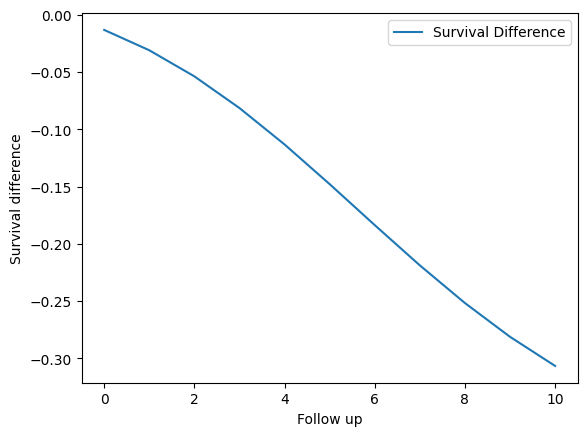

In [32]:
trial_itt.fit_msm(modify_weights=lambda w: np.minimum(w, np.quantile(w, 0.99)))

# Optional Prediction and Plotting for ITT
predict_times = list(range(11))
newdata = trial_itt.outcome_data[trial_itt.outcome_data["trial_period"] == 1]
preds = trial_itt.predict(newdata, predict_times)
plt.plot(preds["difference"]["followup_time"], preds["difference"]["survival_diff"], label="Survival Difference")
plt.xlabel("Follow up")
plt.ylabel("Survival difference")
plt.legend()
plt.show()